# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks

In [126]:
!$ ./CollectSubmission.sh 27

/bin/sh: 1: $: not found


Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Training a CNN model with Inception modules](#1)
2. [Design a better model on CIFAR-10](#2)

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all three parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a compressed file called *team_#.tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage example: ./*CollectSubmission.sh* &nbsp; team_77)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [101]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import os
import numpy as np
from utils.data_utils import load_CIFAR10, plot_images
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
    
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Data has already been downloaded and unpacked.
Train data shape (40000, 32, 32, 3)
Train labels shape (40000,)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


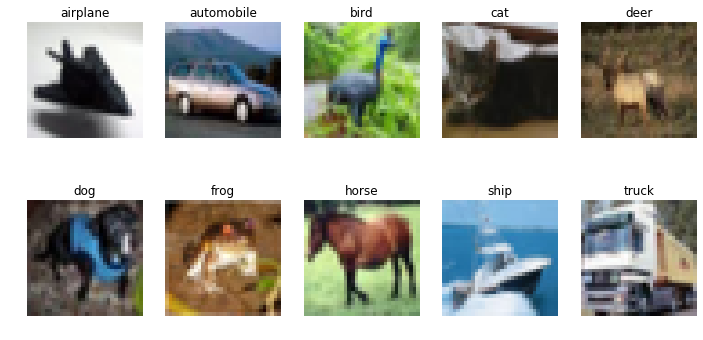

In [102]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Class_names = load_CIFAR10()
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))


plot_images(X_train, Y_train, Class_names, Each_Category=True)

## <a name="1"></a>1. Training a CNN model with Inception module

In this section, you will implement a little more complex CNN model with an `Inception module` [6]. <br>

![Inception_module](utils/InceptionModule_GoogLeNet.png)

Using the code provided as guidance, <br>
**(1)** Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>
**(2)** Define, train, and evaluate a CNN model with the following architecture and training setup:

#### CNN architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
    * 8 filters for the 9x9 convolutions
    * 3x3 max pooling
* `Inception module` with 
    * 8 filters for the main convolutions (blue blocks in the Figure(a))
    * 3 filters for the dimensionality reduction convolutions (yellow blocks in the Figure(a))
    *  ReLU activation
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 5

In [103]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [104]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [105]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 3x3 max-pooling.
    
    
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
#     shape = [filter_size, filter_size, 1, num_filters]
    
    
    
    # Create new weights aka. filters with the given shape.
    
    weights = new_weights(shape=shape)
#     weights_list=[]
#     for i in range(num_input_channels):
#         weights_list=weights_list+new_weights(shape=shape)
    
#     weights=tf.concat(3,weights_list)
        
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    

    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 3, 3, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [106]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [107]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [108]:
def Inception_module(Input, C1, C3_R, C3, C5_R, C5, P3_R):
    '''
    C1, C3, C5: number of filters for the main convolutions
    C3_R, C5_R, P3_R: number of filters for the dimensionality reduction convolutions
    '''
    '''
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    '''
    layer_C1 , weights_C1=new_conv_layer(input=Input,
                           num_input_channels=int(Input.shape[3]),
                           filter_size=1,
                           num_filters=C1,
                           use_pooling=False)
    
    layer_C3_R, weights_C3_R=new_conv_layer(input=Input,
                                           num_input_channels=int(Input.shape[3]),
                                           filter_size=1,
                                           num_filters=C3_R,
                                           use_pooling=False)
    
    layer_C3, weights_C3=new_conv_layer(input=layer_C3_R,
                                       num_input_channels=C3_R,
                                       filter_size=3,
                                       num_filters=C3,
                                       use_pooling=False)
    
    layer_C5_R, weights_C5_R=new_conv_layer(input=Input,
                                           num_input_channels=int(Input.shape[3]),
                                           filter_size=1,
                                           num_filters=C5_R,
                                           use_pooling=False)
    
    layer_C5, weights_C5=new_conv_layer(input=layer_C5_R,
                                       num_input_channels=C5_R,
                                       filter_size=5,
                                       num_filters=C5,
                                       use_pooling=False)
    
    layer_P3=tf.nn.max_pool(value=Input,
                           ksize=[1,3,3,1],
                           strides=[1,1,1,1],
                           padding='SAME')
    
    layer_P3_R , weights_P3_R =new_conv_layer(input=layer_P3,
                                             num_input_channels=int(layer_P3.shape[3]),
                                             filter_size=1,
                                             num_filters=P3_R,
                                             use_pooling=False)
    
    Inception=tf.concat([layer_C1,layer_C3,layer_C5,layer_P3_R],axis=3)
    
    
#     weights = [weights_C1, weights_C3_R, weights_C3, weights_C5_R, weights_C5, weights_P3_R]
    
    '''
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    '''
    return Inception

class inception_model(object):
    def __init__(self):
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        '''
       
        
        self.Input_image=tf.placeholder(tf.float32,shape=[None,32,32,3],name='Input_image')
        
        self.stem_layer1 , self.stem_weights1=new_conv_layer(input=self.Input_image,
                           num_input_channels=int(self.Input_image.shape[3]),
                           filter_size=9,
                           num_filters=8,
                           use_pooling=True)
        
        self.stem_layer2 , self.stem_weights2=new_conv_layer(input=self.stem_layer1,
                           num_input_channels=int(self.stem_layer1.shape[3]),
                           filter_size=9,
                           num_filters=8,
                           use_pooling=True)
        
        self.inception = Inception_module(self.stem_layer2,8,3,8,3,8,3)
        
        self.layer_flat, self.num_features= flatten_layer(self.inception)
        
        self.layer_fc=new_fc_layer(input=self.layer_flat,
                             num_inputs=self.num_features,
                             num_outputs=10,
                             use_relu=True)
        
        self.y_pred=tf.nn.softmax(self.layer_fc)
        
        self.y_pred_cls=tf.argmax(self.y_pred,axis=1)
        
        
        self.y_true_cls=tf.placeholder(tf.int64,shape=[None,],name='y_true_cls')
        
        self.y_true=tf.one_hot(indices=self.y_true_cls,depth=10)
        
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.layer_fc,
                                                        labels=self.y_true)
        
        self.cost = tf.reduce_mean(self.cross_entropy)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.cost)
        
        self.correct_prediction = tf.equal(self.y_pred_cls, self.y_true_cls)
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        '''
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        '''

In [109]:
def Inception_module2(Input, C1, C3_R, C3, C5_R, C5, P3_R):
    '''
    C1, C3, C5: number of filters for the main convolutions
    C3_R, C5_R, P3_R: number of filters for the dimensionality reduction convolutions
    '''
    '''
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    '''
    layer_C1 , weights_C1=new_conv_layer(input=Input,
                           num_input_channels=int(Input.shape[3]),
                           filter_size=1,
                           num_filters=C1,
                           use_pooling=False)
    
    layer_C3_R, weights_C3_R=new_conv_layer(input=Input,
                                           num_input_channels=int(Input.shape[3]),
                                           filter_size=1,
                                           num_filters=C3_R,
                                           use_pooling=False)
    
    layer_C3, weights_C3=new_conv_layer(input=layer_C3_R,
                                       num_input_channels=C3_R,
                                       filter_size=3,
                                       num_filters=C3,
                                       use_pooling=False)
    
    layer_C5_R, weights_C5_R=new_conv_layer(input=Input,
                                           num_input_channels=int(Input.shape[3]),
                                           filter_size=1,
                                           num_filters=C5_R,
                                           use_pooling=False)
    
    layer_C5, weights_C5=new_conv_layer(input=layer_C5_R,
                                       num_input_channels=C5_R,
                                       filter_size=3,
                                       num_filters=C5,
                                       use_pooling=False)
    
    layer_P3=tf.nn.max_pool(value=Input,
                           ksize=[1,3,3,1],
                           strides=[1,1,1,1],
                           padding='SAME')
    
    layer_P3_R , weights_P3_R =new_conv_layer(input=layer_P3,
                                             num_input_channels=int(layer_P3.shape[3]),
                                             filter_size=1,
                                             num_filters=P3_R,
                                             use_pooling=False)
    
    Inception=tf.concat([layer_C1,layer_C3,layer_C5,layer_P3_R],axis=3)
    
    
    weights = [weights_C1, weights_C3_R, weights_C3, weights_C5_R, weights_C5, weights_P3_R]
    
    '''
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    '''
    return (Inception, weights)

In [110]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
def run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    start_time = time.time()
    
    if is_training:
        for i in range(epochs):

            idx=np.random.randint(X.shape[0],size=batch_size)
        
            
            X_train_batch=X[idx,:]
            
            Y_train_batch=Y[idx]
            
            feed_dict_train = {model.Input_image: X_train_batch,
                               
                               model.y_true_cls: Y_train_batch}

            session.run(model.optimizer, feed_dict=feed_dict_train)

 # Ending time.
        end_time = time.time()

    # Difference between start and end-times.
        time_dif = end_time - start_time

    # Print the time-usage.
        print("#Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        '''
        print("#Training done!")

    # Evaluate loss and accuracy of the model
    else:
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        '''
#         loss=model.cross_entropy
        
#         accuracy=model.correct_prediction
        
       

        feed_dict = {model.Input_image: X,
                       model.y_true_cls: Y}
        
        accuracy = session.run(model.accuracy, feed_dict = feed_dict)
         
        loss = session.run(model.cost, feed_dict = feed_dict)

        
        
        
#         accuracy=int(accuracy)
        
        
        
        '''
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        '''
        return (loss, accuracy)

In [111]:
# Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = inception_model()    
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    run_model(sess, model, X_train, Y_train, is_training=True, epochs=5)
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

#Time usage: 0:00:00
#Training done!
(Loss, Accuracy) on Training Dataset (2.3022, 0.10)
(Loss, Accuracy) on Validataion Dataset (2.3017, 0.11)


## <a name="2"></a>2. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation

In [112]:
def backprop(layer,y_true,y_true_cls, learning_rate=1e-4):
        layer_flat, num_features= flatten_layer(layer)
        
        layer_fc=new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=10,
                             use_relu=True)
        
#         y_pred=tf.nn.softmax(layer_fc)
        
#         y_pred_cls=tf.argmax(y_pred,axis=1)
        
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc,
                                                        labels=y_true)
        
        cost = tf.reduce_mean(cross_entropy)
        
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        
#         correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        

In [113]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
def my_run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    start_time = time.time()
    
    if is_training:
        for i in range(epochs):

            idx=np.random.randint(X.shape[0],size=batch_size)
            
            
            X_train_batch=X[idx,:]
            
            Y_train_batch=Y[idx]
            
            feed_dict_train = {model.Input_image: X_train_batch,
                               
                               model.y_true_cls: Y_train_batch}

            session.run(model.optimizer, feed_dict=feed_dict_train)

 # Ending time.
        end_time = time.time()

    # Difference between start and end-times.
        time_dif = end_time - start_time

    # Print the time-usage.
        print("#Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        '''
#         print("#Training done!")

    # Evaluate loss and accuracy of the model
    else:
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        '''
#         loss=model.cross_entropy
        
#         accuracy=model.correct_prediction
        
       

        feed_dict = {model.Input_image: X,
                       model.y_true_cls: Y}
        
        accuracy = session.run(model.accuracy, feed_dict = feed_dict)
         
        loss = session.run(model.cost, feed_dict = feed_dict)

        
        
        
#         accuracy=int(accuracy)
        
        
        
        '''
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        '''
        return (loss, accuracy)

In [114]:
class my_model(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        #################Try GoogleNet structure################################
        
        self.learning_rate=1e-2
        
        self.inception_number=1
        
        self.Input_image=tf.placeholder(tf.float32,shape=[None,32,32,3],name='Input_image')
        
        self.Input_image_norm = tf.contrib.layers.batch_norm(self.Input_image, 
                                          center=True, scale=True, 
                                          is_training=True)
        
        self.y_true_cls=tf.placeholder(tf.int64,shape=[None,],name='y_true_cls')
        
        self.y_true=tf.one_hot(indices=self.y_true_cls,depth=10)
        
  
        self.stem_layer1 , self.stem_weights1=new_conv_layer(input=self.Input_image_norm,
                           num_input_channels=int(self.Input_image.shape[3]),
                           filter_size=9,
                           num_filters=8,
                           use_pooling=True)
        
        

            
            
#         self.stem_layer1 = tf.nn.dropout(self.stem_layer1,keep_prob=0.7)
        
        self.stem_layer2 , self.stem_weights2=new_conv_layer(input=self.stem_layer1,
                           num_input_channels=int(self.stem_layer1.shape[3]),
                           filter_size=9,
                           num_filters=8,
                           use_pooling=True)
        
        
    
#         self.stem_layer2 = tf.nn.dropout(self.stem_layer2,keep_prob=0.7)
        
        self.inception = Inception_module(self.stem_layer2,8,3,8,3,8,3)
        
        self.inception_arr=[]
        
        self.inception_arr=self.inception_arr+[self.inception]
        for i in range(self.inception_number-1):
            self.inception_arr=self.inception_arr+[Inception_module(self.inception_arr[i],8,3,8,3,8,3)]
            self.inception_arr[i+1] = tf.contrib.layers.batch_norm(self.inception_arr[i+1], 
                                          center=True, scale=True, 
                                          is_training=True,
                                          scope='bn')
            
            self.inception_arr[i+1] = tf.nn.relu(self.inception_arr[i+1],'relu')
            '''
        for i in range(self.inception_number-1):
            self.inception=Inception_module(self.inception,8,3,8,3,8,3)
            
            self.inception = tf.contrib.layers.batch_norm(self.inception, 
                                          center=True, scale=True, 
                                          is_training=True,
                                          scope='bn')
            
            self.inception = tf.nn.relu(self.inception,'relu')
            
#             self.inception = tf.nn.dropout(self.inception,keep_prob=0.4)
        '''
        
#         self.inception_dropout = tf.nn.dropout(self.inception_arr[self.inception_number-1],keep_prob=0.75)
        
        self.stem_layer_inception , self.stem_weights_inception=new_conv_layer(input=self.inception_arr[self.inception_number-1],
                           num_input_channels=int(self.inception_arr[self.inception_number-1].shape[3]),
                           filter_size=9,
                           num_filters=8,
                           use_pooling=True)
        
        self.layer_flat, self.num_features= flatten_layer(self.stem_layer_inception)
        
        self.layer_fc=new_fc_layer(input=self.layer_flat,
                             num_inputs=self.num_features,
                             num_outputs=10,
                             use_relu=True)
        
        self.layer_fc = tf.contrib.layers.batch_norm(self.layer_fc, 
                                          center=True, scale=True, 
                                          is_training=True,
                                          scope='bn')
        
#         self.layer_fc = tf.nn.dropout(self.layer_fc,keep_prob=0.5)
        
        self.layer_fc=tf.nn.relu(self.layer_fc, 'relu')
        
        self.y_pred=tf.nn.softmax(self.layer_fc)
        
        self.y_pred_cls=tf.argmax(self.y_pred,axis=1)
        
        
        
        
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.layer_fc,
                                                        labels=self.y_true)
        
        self.cost = tf.reduce_mean(self.cross_entropy)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
        self.correct_prediction = tf.equal(self.y_pred_cls, self.y_true_cls)
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        

In [115]:
def new_conv_layer_new(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   conv_strides,
                   pool_size,
                   pool_strides,
                   use_pooling=True):  # Use 3x3 max-pooling.
##################--Whats New Here--#################################
# 1. Can give conv_strides and pool_strides as input
# 2. Can give already_trained weights as input
####################################################################
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
#     shape = [filter_size, filter_size, 1, num_filters]
    

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, conv_strides, conv_strides, 1],
                         padding='SAME')                           

    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, pool_size, pool_size, 1],
                               strides= [1, pool_strides, pool_strides, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [116]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
import copy
def run_model_v2(session, model, X, Y, epochs=1, batch_size=500, is_training=False, learn_rate = "slow"):
    # For training the model
    start_time = time.time()
    mode = 0
    acc = 0
    new_acc = 0
    best_train_acc = 0
    best_val_acc = 0
    val_acc = 0
    i_learning_rate = copy.deepcopy(model.learning_rate)
    i_l2_constant = copy.deepcopy(model.l2_constant)
    feed_dict_val_acc = {model.Input_image: X_val,
                       model.y_true_cls: Y_val,
                         model.is_training : False}
    feed_dict_train_acc = {model.Input_image: X,
                            model.y_true_cls: Y,
                            model.is_training : False}
        
    if is_training:
        for i in range(epochs):
            
            idx=np.random.randint(X.shape[0],size=batch_size)
        
            
            X_train_batch=X[idx,:]
            
            Y_train_batch=Y[idx]
            
            feed_dict_train = {model.Input_image: X_train_batch,
                               model.y_true_cls: Y_train_batch,
                               model.is_training : True}
            
            if(i%100 == 0):
                new_acc = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                new_acc = np.round(new_acc, 4)
                if(new_acc>best_train_acc):
                    best_train_acc = new_acc
                    val_acc = session.run(model.accuracy, feed_dict = feed_dict_val_acc)
                    val_acc = np.round(val_acc, 4)
                    if(val_acc > best_val_acc):
                        best_val_acc = val_acc
                    print("#",i," accuracy: ",new_acc, " improvement: ", np.round(new_acc - acc, 4), "best train accuracy:",best_train_acc, "validation accuracy: ", val_acc, best_val_acc)
                else:
                    print("iteration:",i," accuracy: ",new_acc, " improvement: ", np.round(new_acc - acc, 4))
                acc = new_acc
            model.learning_rate = i_learning_rate*np.random.randint(100)/50
            model.l2_constant = i_l2_constant*np.random.randint(100)/50
            
            if(mode == 0):      
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/50) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.4):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 0 to 1 at iteration: %d",i)
            if (mode == 1):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/50) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.45):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 1 to 2 at iteration: %d",i)                
            if(mode == 2):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/50) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.50):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 2 to 3 at iteration: %d",i)
            if (mode == 3):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/50) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.55):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 3 to 4 at iteration: %d",i)     
            if(mode == 4):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/50) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.60):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 4 to 5 at iteration: %d",i)
            if (mode == 5):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/100) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.65):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 5 to 6 at iteration: %d",i)           
            if(mode == 6):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/100) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.70):
                        mode = mode + 1
                        i_learning_rate /= 3
                        print("mode 6 to 7 at iteration: %d",i)
            if (mode == 7):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/100) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.75):
                        mode = mode + 1
                        i_learning_rate /= 100
                        print("mode 7 to 8 at iteration: %d",i)
            if (mode == 8):
                session.run(model.optimizer, feed_dict=feed_dict_train)
                if (i%(epochs/100) == 0):
                    accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
                    if(accuracy >= 0.80):
                        mode = mode + 1
                        i_learning_rate /= 100
                        print("mode 8 to 9 at iteration: %d",i)
            if (mode == 9):
                session.run(model.optimizer, feed_dict = feed_dict_train)

     # Ending time.
        end_time = time.time()

    # Difference between start and end-times.
        time_dif = end_time - start_time

    # Print the time-usage.
        print("#Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        print("#Training done!")

    # Evaluate loss and accuracy of the model
    else:
        accuracy = session.run(model.accuracy, feed_dict = feed_dict_train_acc)
         
        loss = session.run(model.cost, feed_dict = feed_dict_train_acc)

        return (loss, accuracy)

In [117]:
###
'''
start_time=time.time()

# Clear old variables
tf.reset_default_graph()    

# Declare out simple model

model = my_model()
model.learning_rate=1e-10
model.inception_number=1
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    
    sess.run(tf.global_variables_initializer())
    
    my_run_model(sess, model, X_train, Y_train, batch_size=500, is_training=True, epochs=1000)
    
    print(my_run_model(sess,model,X_train, Y_train, is_training=False))
    print("#(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    
#     model.learning_rate=1e-4
    
    mode=0
    for i in range(2,8):
      model.inception_number=i
#       model.learning_rate=model.learning_rate/10
      
#       self.learning_rate*=10
      
      if(mode==0 and my_run_model(sess,model,X_train, Y_train, is_training=False)[1]>0.5):
            print("mode 0 to 1")
#             model.learning_rate*=10
            mode=mode+1
      if(mode==1 and my_run_model(sess,model,X_train, Y_train, is_training=False)[1]>0.6):
            print("mode 1 to 2")
#             model.learning_rate*=10
            mode=mode+1
      if(mode==2 and my_run_model(sess,model,X_train, Y_train, is_training=False)[1]>0.7):
            print("mode 2 to 3")
            model.learning_rate*=10
            mode=mode+1
      my_run_model(sess,model,X_train, Y_train, batch_size=500, is_training=True, epochs=1000)
      print(my_run_model(sess,model,X_train, Y_train, is_training=False))
      print("#(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    print("#(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("#(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    
    end_time=time.time()
    time_dif = end_time - start_time

   
    print("#total Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    #Save your final model
    saver = tf.train.Saver()
    saver.save(sess, "./model_checkpoints/my_model_final")
    '''

'\nstart_time=time.time()\n\n# Clear old variables\ntf.reset_default_graph()    \n\n# Declare out simple model\n\nmodel = my_model()\nmodel.learning_rate=1e-10\nmodel.inception_number=1\n# Now, create a tf.Session and train the model\nwith tf.Session(config=conf) as sess:\n    ##############################################################################\n    #                          IMPLEMENT YOUR CODE                               #\n    ##############################################################################\n    \n    sess.run(tf.global_variables_initializer())\n    \n    my_run_model(sess, model, X_train, Y_train, batch_size=500, is_training=True, epochs=1000)\n    \n    print(my_run_model(sess,model,X_train, Y_train, is_training=False))\n    print("#(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))\n    \n#     model.learning_rate=1e-4\n    \n    mode=0\n    for i in range(2,8):\n      model.inception_number=i\n#       model.lea

In [120]:
class my_model_simple1(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        #################Try GoogleNet structure################################
        
        #The input layer
        self.Input_image=tf.placeholder(tf.float32,shape=[None,32,32,3],name='Input_image')
        self.is_training = tf.placeholder(tf.bool)
        ###################The labels#########################
        self.y_true_cls=tf.placeholder(tf.int64,shape=[None,],name='y_true_cls')
        self.y_true=tf.one_hot(indices=self.y_true_cls,depth=10)
        ######################################################
        self.learning_rate = 5e-4
        #The first stem layer
        
        ############ data augmentation ##########################
        rand_angle=random.uniform(0,360)
        rand_int=random.randrange(0,4) # random number for rotation and flip
        
        self.Input_image_aug=tf.contrib.image.rotate(images=self.Input_image,angles=rand_angle)
       
        if(rand_int==1):
            self.Input_image_aug=tf.image.random_flip_left_right(self.Input_image_aug)
        elif(rand_int==2):
            self.Input_image_aug=tf.image.random_flip_up_down(self.Input_image_aug)
        elif(rand_int==3):
            self.Input_image_aug=tf.image.random_flip_left_right(self.Input_image_aug)
            self.Input_image_aug=tf.image.random_flip_up_down(self.Input_image_aug)
        
        self.Input_image_aug=tf.contrib.image.translate(images=self.Input_image_aug,
                                                       translations=[random.randrange(-14,14),
                                                                     random.randrange(-14,14)])
        

        
        
        ##########################################################
        self.stem_layer1 , self.stem_weights1=new_conv_layer_new(input=self.Input_image,
                                num_input_channels=int(self.Input_image.shape[3]),
                                filter_size=4,
                                num_filters=32,
                                conv_strides = 2,
                                pool_size = 3,
                                pool_strides = 2,
                                use_pooling=True)
        self.stem_layer1 = tf.layers.batch_normalization(self.stem_layer1, training = self.is_training)
        #The first inception layer
        self.inception1, self.iweight1 = Inception_module2(self.stem_layer1,8,12,16,2,4,4)
        
        #The second inception layer
        self.inception2, self.iweight2 = Inception_module2(self.inception1,16,16,24,4,12,8)
        
        #################The output layer#######################
        self.inception2 = tf.nn.dropout(self.inception2,
                                        keep_prob=0.6
                                    )
        self.layer_flat_out, self.num_features_out= flatten_layer(self.inception2)                
        self.layer_fc_out=new_fc_layer(input=self.layer_flat_out,
                             num_inputs=self.num_features_out,
                             num_outputs=10,
                             use_relu=True)
        self.y_pred_out=tf.nn.softmax(self.layer_fc_out)
        self.y_pred_cls_out=tf.argmax(self.y_pred_out,axis=1)
        self.cross_entropy_out = tf.nn.softmax_cross_entropy_with_logits(logits=self.layer_fc_out,
                                                        labels=self.y_true)
        self.l2_constant = 1e-3
        self.vars   = tf.trainable_variables() 
        self.lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in self.vars ]) * self.l2_constant
        self.cost_out = tf.reduce_mean(self.cross_entropy_out+self.lossL2)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost_out)
        ##################################################################
        
        #The cost
        self.cost = self.cost_out
        
        #The accuracy
        self.correct_prediction = tf.equal(self.y_pred_cls_out, self.y_true_cls)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        

In [121]:
# Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = my_model_simple1()    
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    
    sess.run(tf.global_variables_initializer())
    
    run_model_v2(sess, model, X_train, Y_train, batch_size = 77, is_training=True, epochs=100000)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    print("#(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model_v2(sess, model, X_train, Y_train, is_training = False))
    print("#(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model_v2(sess, model, X_val, Y_val, is_training = False))
    
    #Save your final model
    saver = tf.train.Saver()
    saver.save(sess, "./model_checkpoints/my_model_final")
    

# 0  accuracy:  0.1089  improvement:  0.1089 best train accuracy: 0.1089 validation accuracy:  0.1078 0.1078
# 100  accuracy:  0.325  improvement:  0.2161 best train accuracy: 0.325 validation accuracy:  0.3238 0.3238
# 200  accuracy:  0.4128  improvement:  0.0878 best train accuracy: 0.4128 validation accuracy:  0.4103 0.4103
# 300  accuracy:  0.447  improvement:  0.0342 best train accuracy: 0.447 validation accuracy:  0.4333 0.4333
# 400  accuracy:  0.4763  improvement:  0.0293 best train accuracy: 0.4763 validation accuracy:  0.4718 0.4718
# 500  accuracy:  0.4902  improvement:  0.0139 best train accuracy: 0.4902 validation accuracy:  0.487 0.487
# 600  accuracy:  0.5109  improvement:  0.0207 best train accuracy: 0.5109 validation accuracy:  0.4994 0.4994
# 700  accuracy:  0.5321  improvement:  0.0212 best train accuracy: 0.5321 validation accuracy:  0.5205 0.5205
iteration: 800  accuracy:  0.5286  improvement:  -0.0035
# 900  accuracy:  0.5431  improvement:  0.0145 best train accur

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

In our model, first we put one convolution layer for stem layer and put batch normalization layer to deal with gradient decreasing faster or gradient exploding. After that, we put two inception module for learning and dropout layers for generalization. Finally, we connected this inception modules serially with flatten layer and dense fully connected layer to make 10 output. And we take softmax function to 10 outputs and select what is the best classification decision. 
At running model, we thought that little batch size will helpful for performance and generalization, so we used only 77 batch size, but 20000 epochs. while running, we check training accuracy each 400 iteration, if accuracy becomes higher than one threshold, we changed mode and we decayed learning rate. We made 8 accuracy threshold, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8 and each step, learning rate becomes 3 times smaller than before.

_Tell us here_

### Test Set - Do this only once
Now that you've gotten a result that you're happy with, test your final model on the test set. This would be the score you would achieve on a competition. Think about how this compares to your validation set accuracy.

In [123]:
# Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Load your final model
    model = my_model_simple1()
    saver = tf.train.Saver()
    saver.restore(sess, "./model_checkpoints/my_model_final")
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % run_model_v2(sess, model, X_test, Y_test))

INFO:tensorflow:Restoring parameters from ./model_checkpoints/my_model_final
(Loss, Accuracy) on Test Dataset (1.0317, 0.72)
